# Never on a Friday or Turning Tuesday
People in financial world especially traders talk about "Turning Tuesdays". The [idea](https://www.advisorperspectives.com/commentaries/2013/06/07/never-on-a-friday) is basically if the markets is down for several days in a row, it will never turn around on Friday because traders don't want to stay in a position over the weekend. Their pessism looms over the weekend. Likewise, on a Monday, traders have been sitting around depressed for the whole weekend (because the market is down) so Monday will stay down. It's on Tuesday that more rational heads prevail, so a down market will more likely "turn around" on a Tuesday. Hence **Turning Tuesday**.

### Let's see if data says the same.


In [1]:
import pandas as pd
import numpy as np

We will analyze sp-500 data to see if these facts line up.

In [2]:
sp500 = pd.read_csv('data/table.csv', index_col=0, parse_dates=True)
sp500.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2016-01-11,1926.119995,1935.650024,1901.099976,1923.670044,4607290000,1923.670044
2016-01-08,1985.319946,1985.319946,1918.459961,1922.030029,4664940000,1922.030029
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,5076590000,1943.089966
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,4336660000,1990.260010
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,3706620000,2016.709961


In [3]:
sp500tt = sp500[['Adj Close']]
sp500tt.head()

,Adj Close
Date,
2016-01-11,1923.670044
2016-01-08,1922.030029
2016-01-07,1943.089966
2016-01-06,1990.260010
2016-01-05,2016.709961


In [4]:
sp500tt.tail()

,Adj Close
Date,
1950-01-09,17.08
1950-01-06,16.98
1950-01-05,16.93
1950-01-04,16.85
1950-01-03,16.66


In [5]:
sp500.index

DatetimeIndex(['2016-01-11', '2016-01-08', '2016-01-07', '2016-01-06',
               '2016-01-05', '2016-01-04', '2015-12-31', '2015-12-30',
               '2015-12-29', '2015-12-28',
               ...
               '1950-01-16', '1950-01-13', '1950-01-12', '1950-01-11',
               '1950-01-10', '1950-01-09', '1950-01-06', '1950-01-05',
               '1950-01-04', '1950-01-03'],
              dtype='datetime64[ns]', name='Date', length=16613, freq=None)

### Which days did the market go up or down?

In [6]:
def relative_change(x):
    return (x[0] - x[1])/x[1]

*Sidenote*: You can get Pandas documentation open by using `?`

`sp500_adj_close.assign?`

In [7]:
sp500tt = sp500tt.assign(up_down=sp500tt.rolling(2)
                         .apply(relative_change, raw=True))
sp500tt.head()

,Adj Close,up_down
Date,,
2016-01-11,1923.670044,NaN
2016-01-08,1922.030029,0.000853
2016-01-07,1943.089966,-0.010838
2016-01-06,1990.260010,-0.023700
2016-01-05,2016.709961,-0.013115


we need to shift the results "up" one. January 11 was an "up" day, but its entry is one row too low in the "up_down" column

In [8]:
sp500tt.up_down = sp500tt.up_down.shift(-1)

In [9]:
sp500tt.iloc[0:10]

,Adj Close,up_down
Date,,
2016-01-11,1923.670044,0.000853
2016-01-08,1922.030029,-0.010838
2016-01-07,1943.089966,-0.023700
2016-01-06,1990.260010,-0.013115
2016-01-05,2016.709961,0.002012
2016-01-04,2012.660034,-0.015304
2015-12-31,2043.939941,-0.009412
2015-12-30,2063.360107,-0.007217
2015-12-29,2078.360107,0.010630


In [10]:
sp500tt.head()

,Adj Close,up_down
Date,,
2016-01-11,1923.670044,0.000853
2016-01-08,1922.030029,-0.010838
2016-01-07,1943.089966,-0.023700
2016-01-06,1990.260010,-0.013115
2016-01-05,2016.709961,0.002012


In [11]:
sp500tt.tail()

,Adj Close,up_down
Date,,
1950-01-09,17.08,0.005889
1950-01-06,16.98,0.002953
1950-01-05,16.93,0.004748
1950-01-04,16.85,0.011405
1950-01-03,16.66,NaN


Lets get which day each of these dates falls on. We will use `datetime`'s `dayOfWeek` to get that information. `0` represents Monday.. `6` represents a Sunday

In [12]:
sp500tt['day_num'] = sp500tt.index.dayofweek
sp500tt.head()

,Adj Close,up_down,day_num
Date,,,
2016-01-11,1923.670044,0.000853,0
2016-01-08,1922.030029,-0.010838,4
2016-01-07,1943.089966,-0.023700,3
2016-01-06,1990.260010,-0.013115,2
2016-01-05,2016.709961,0.002012,1


We will consider market is down if there are three or more consecutive days if the market closed lower than it opened. So for example, for a Friday, we will check 3 previous trading Tuesday, Wednesady and Thursday. Therefore, question we eventually want to answer, with above definition of down market, do we bounce back on Tuesday more often than other days.

In [13]:
def down_last_three_days(x):
    if x[1] <= 0 and x[2] <= 0 and x[3] <= 0:
        return True
    else:
        return False

In [14]:
sp500tt['down_last_three_days'] = \
    sp500tt['up_down'].rolling(4).apply(down_last_three_days, raw=True).shift(-3)

In [15]:
sp500tt.head()

,Adj Close,up_down,day_num,down_last_three_days
Date,,,,
2016-01-11,1923.670044,0.000853,0,1.0
2016-01-08,1922.030029,-0.010838,4,0.0
2016-01-07,1943.089966,-0.023700,3,0.0
2016-01-06,1990.260010,-0.013115,2,0.0
2016-01-05,2016.709961,0.002012,1,1.0


In [16]:
len(sp500tt)

16613

In [18]:
sp500tt['turned'] = (sp500tt['down_last_three_days'] == 1.0) & (sp500tt['up_down'] > 0.0)

In [19]:
sp500tt.head()

,Adj Close,up_down,day_num,down_last_three_days,turned
Date,,,,,
2016-01-11,1923.670044,0.000853,0,1.0,True
2016-01-08,1922.030029,-0.010838,4,0.0,False
2016-01-07,1943.089966,-0.023700,3,0.0,False
2016-01-06,1990.260010,-0.013115,2,0.0,False
2016-01-05,2016.709961,0.002012,1,1.0,True


Now we will group this by each day of the week and see if Tuesdays are really "Turning Tuesday"s

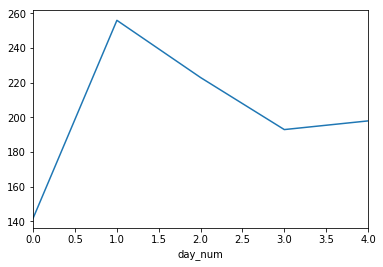

In [21]:
sp_turning_days_totals = sp500tt.turned.groupby(sp500tt.day_num).sum()
%matplotlib inline
sp_turning_days_totals.plot()

Clearly! Tuesdays are winner